Adapted from BERT/CSProjectNoisy.ipynb

In [1]:
import pandas as pd
import numpy as np
from transformers import GPT2TokenizerFast
from transformers import GPT2ForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import re
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [76]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
## Reading the full data
full_train_data = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin-1',sep=',',
                              names=['Polarity','tweetID','date','query','user','text'])

In [3]:
# Reading full test data
full_test_data = pd.read_csv('full_testing_data_noneutral.csv')

In [9]:
## Defining the preprocessing function removing twitter handles ,  website links , digits and double spacing
def preprocessing(tweet):
  temp = tweet.lower()
  temp = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', ' ', temp)
  temp = re.sub(r'https\S+', '', temp)
  temp = re.sub(r'http\S+', '', temp)
  temp = re.sub(r'www\S+', '', temp)
#   temp = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", " ", temp)
  temp = re.sub("[0-9]", " ", temp)
  temp = re.sub("\s\s+", " ", temp)
  return temp

In [10]:
full_test_data.iloc[5,:].tweet_text

'My #cre blog Oklahoma Per Square Foot returns to the @JournalRecord blog hub tomorrow. I will have some interesting local data to share.'

In [11]:
full_test_data.shape

(14908, 4)

In [12]:
full_test_data.iloc[3,:].tweet_text

'@firecore Can you tell me when an update for the Apple TV 3rd gen becomes available? The missing update holds me back from buying #appletv3'

In [13]:
full_test_data.iloc[1]

Unnamed: 0                                                    2
sentiment                                              negative
tweet_text    Kapan sih lo ngebuktiin,jan ngomong doang Susa...
label                                                         0
Name: 1, dtype: object

In [14]:
preprocessed_test_tweets = []
labels = []
for i in tqdm(range(full_test_data.shape[0])):
    row_val = full_test_data.iloc[i]
    #if row_val.label == 1:
    #    continue
    tweet = preprocessing(row_val.tweet_text)
    preprocessed_test_tweets.append(tweet)
    if row_val.label == 2 or row_val.label==1:
        labels.append(1)
    else:
        labels.append(0)

100%|██████████| 14908/14908 [00:01<00:00, 8203.69it/s]


In [15]:
test_info = {'Polarity':labels,'text':preprocessed_test_tweets}
full_test_data = pd.DataFrame(data=test_info)
full_test_data.to_csv("full_test_data.csv",index=True)

In [16]:
full_test_data.Polarity.value_counts()

1    10552
0     4356
Name: Polarity, dtype: int64

In [ ]:
columns = full_train_data.columns

In [13]:
columns

Index(['Polarity', 'tweetID', 'date', 'query', 'user', 'text'], dtype='object')

In [14]:
pre_processed_all_tweets = []
for tweet in tqdm(full_train_data.text):
  tweet = preprocessing(tweet)
  pre_processed_all_tweets.append(tweet)

100%|██████████| 1600000/1600000 [00:10<00:00, 150549.78it/s]


In [15]:
info = {'Polarity':full_train_data['Polarity'],'text':pre_processed_all_tweets}
full_training_data = pd.DataFrame(data = info)

In [16]:
## Changing the polarity of the positive tweet to 1
full_training_data['Polarity'].mask(full_training_data['Polarity'] == 4, 1, inplace=True)

In [17]:
## Writing to CSV file
full_training_data.to_csv("full_training_data.csv",index=True)

In [18]:
X_training_data_full = full_training_data.text.tolist()
Y_training_data_full = full_training_data.Polarity.tolist()

In [18]:
X_testing_data = full_test_data.text.tolist()
Y_testing_data = full_test_data.Polarity.tolist()

In [67]:
# Using the BERT tokenizer to tokenize the values
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2',
                                         do_lower_case = True)
tokenizer.pad_token = tokenizer.eos_token

In [21]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(X_training_data_full,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr4/cs505/tvranga/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [68]:
#encode test set
encoded_data_test = tokenizer.batch_encode_plus(X_testing_data,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr4/cs505/tvranga/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(Y_training_data_full)


In [69]:
#test set
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(Y_testing_data)

In [54]:
label_dict = {'Negative' : 0 , 'Positive' : 1}

In [26]:
model = GPT2ForSequenceClassification.from_pretrained('gpt2',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

In [70]:
#test set
dataset_test = TensorDataset(input_ids_test, 
                              attention_masks_test,
                              labels_test)

In [ ]:
validation_set_size = int(len(dataset_train)*0.2)
train_set_size = int(len(dataset_train) - validation_set_size)

In [30]:
validation_dataset,train_dataset = torch.utils.data.random_split(dataset_train, [validation_set_size, train_set_size], generator=torch.Generator().manual_seed(42))

In [31]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
torch.cuda.memory_allocated(device=device)

0

In [34]:
batch_size = 32
#train set
dataloader_train = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)
dataloader_val = DataLoader(validation_dataset,sampler = RandomSampler(validation_dataset),
                              batch_size = batch_size)

In [73]:
#test set
batch_size = 32
dataloader_test = DataLoader(dataset_test,batch_size = batch_size,shuffle=True,drop_last=True)

In [36]:
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)


/usr4/cs505/tvranga/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
label_dict = {'Negative' : 0 , 'Positive' : 1}

In [59]:
def evaluate(dataloader_val,model):

    model.cuda()
    #evaluation mode 
    model.eval()
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.cuda() for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [60]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [61]:
def accuracy_per_class(preds, labels):
    label_dict = {'Negative' : 0 , 'Positive' : 1}
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')
    
    print(f'Total accuracy is : {accuracy_score(labels_flat,preds_flat)}\n')
    
    
    return accuracy_score(labels_flat,preds_flat)    
    

In [ ]:
train_loss = []
val_loss_total = []
for epoch in tqdm(range(1,epochs+1)):
    
    model.cuda()
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    counter = 0
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
        batch = tuple(b.cuda() for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        counter += 1
#         if counter%2000 == 0:
#             print("Epoch: {}/{}...".format(epoch, epochs),
#                     "Step: {}...".format(counter),
#                     "Loss: {}...".format(loss.item()))
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'Models/ GPT2_ft_noisy_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    train_loss.append(loss_train_ave)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val,model)
    val_loss_total.append(val_loss)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    accuracy = accuracy_per_class(predictions, true_vals)
    
    dict1 = {'Validation_loss':val_loss,'Training_loss':loss_train_ave,'validation_F1':val_f1,'Validation_Acc':accuracy}
    with open(f'Data/ Epoch_{epoch}_data.pickle', 'wb') as f:
        pickle.dump(dict1, f)   
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

In [42]:
def read_data():
    validation_loss = []
    training_loss = []
    f1_scores = []
    validation_acc = []
    for i in range(0,7):
        file = 'Data/ Epoch_'+str(i)+'_data.pickle'
        with open(file, 'rb') as f:
            dict1 = pickle.load(f, encoding='latin1')
            validation_loss.append(dict1['Validation_loss'])
            training_loss.append(dict1['Training_loss'])
            f1_scores.append(dict1['validation_F1'])
            validation_acc.append(dict1['Validation_Acc'])
    return validation_loss,training_loss,f1_scores,validation_acc


In [44]:
val_loss,train_loss,f1_scores,val_acc = read_data()

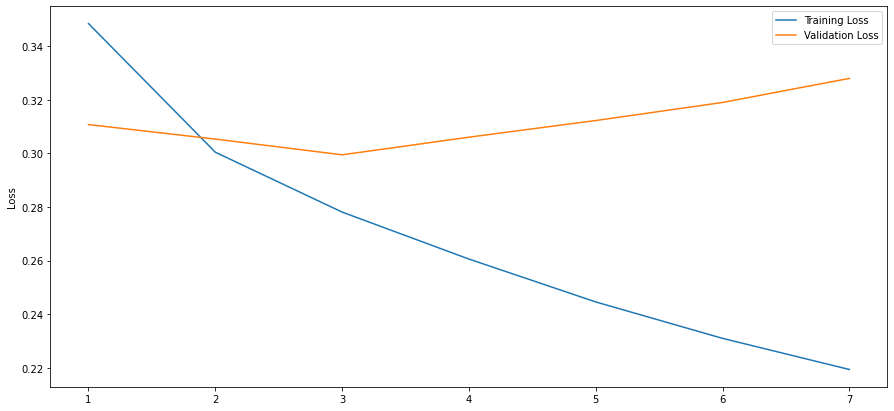

In [86]:
plt.figure(figsize=(15, 7))
RANGE = range(1, 8)
plt.plot(RANGE, train_loss,
         label = "Training Loss")
plt.plot(RANGE, val_loss, label = "Validation Loss")

plt.xticks(RANGE)
plt.ylabel('Loss')
plt.legend()
plt.savefig('current_Status.png')
plt.show()

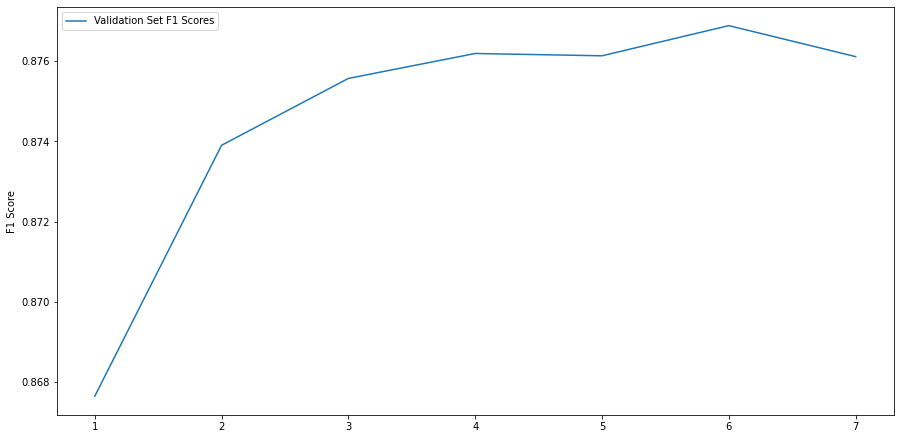

Max F1 Score at Epoch 6: 0.8768905773588047


In [87]:
plt.figure(figsize=(15, 7.5))
plt.plot(RANGE, f1_scores , label='Validation Set F1 Scores')
plt.ylabel('F1 Score')
plt.xticks(RANGE)
plt.legend()
plt.show()
max_value = max(f1_scores)
max_index = f1_scores.index(max_value) + 1
print(f"Max F1 Score at Epoch {max_index}: {max_value}")

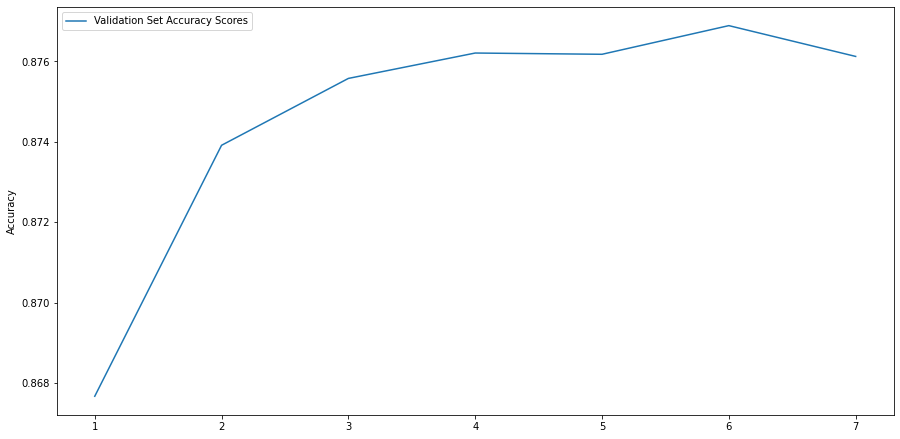

Max Accuracy Score at Epoch 6: 0.876890625


In [88]:
plt.figure(figsize=(15, 7.5))
plt.plot(RANGE, val_acc , label='Validation Set Accuracy Scores')
plt.ylabel('Accuracy')
plt.xticks(RANGE)
plt.legend()
plt.show()
max_value = max(val_acc)
max_index = val_acc.index(max_value) + 1
print(f"Max Accuracy Score at Epoch {max_index}: {max_value}")


In [89]:
def plot_confusion(y_test,y_pred):
    #Generate the confusion matrix
    y_pred = np.argmax(y_pred, axis = 1).flatten()
    cf_matrix = confusion_matrix(y_test, y_pred)
    return cf_matrix

In [55]:
model =  GPT2ForSequenceClassification.from_pretrained('gpt2',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
#The models were stored from numbers 0-7 and not 1-8. Hence the difference in the filename
model.load_state_dict(torch.load(f'Models/ GPT2_ft_noisy_epoch5.model'))

<All keys matched successfully>

In [74]:
loss_test_avg, predictions, true_vals = evaluate(dataloader_test,model)

100%|██████████| 465/465 [01:14<00:00,  6.25it/s]


In [77]:
matrix = plot_confusion(true_vals,predictions)

In [78]:
print(matrix)

[[3319 1031]
 [2008 8522]]


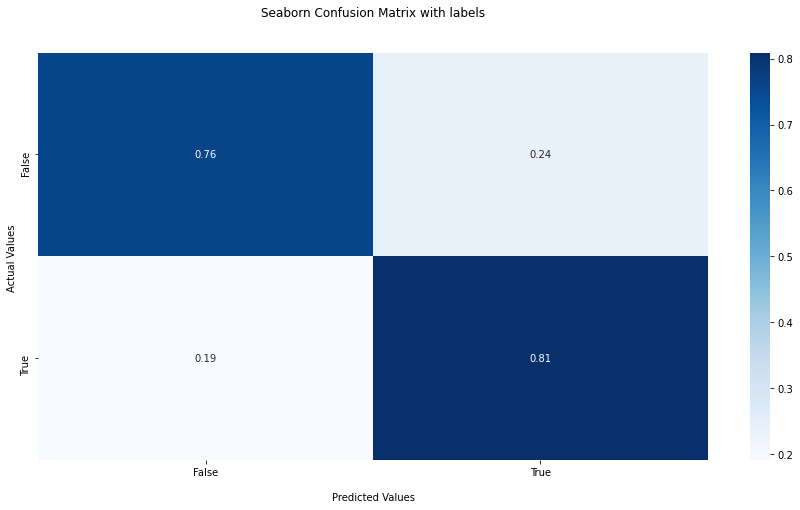

In [79]:
import seaborn as sns
plt.figure(figsize=(15, 7.5))

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [80]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy:3319/4350

Class: Positive
Accuracy:8522/10530

Total accuracy is : 0.7957661290322581



0.7957661290322581

In [81]:
print("F1 score is: ",f1_score_func(predictions, true_vals))

F1 score is:  0.8011081652631046
